In [36]:
import numpy as np
import pandas as pd

from itertools import groupby
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import f1_score, accuracy_score
from pandas.api.types import is_datetime64_ns_dtype

from catboost import CatBoostClassifier
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
import gc

import warnings
warnings.filterwarnings("ignore")

In [37]:
TRAIN_PATH = '/kaggle/input/zzz-data/Zzzs_train.parquet'

In [38]:
series_id  = pd.read_parquet(TRAIN_PATH, columns=['series_id'])
series_id = series_id['series_id'].unique()

weird_series = ['31011ade7c0a', 'a596ad0b82aa']
series_id = [s for s in series_id if s not in weird_series]

In [39]:
def basic_fe(df, periods):
    
    df['series_id'] = df['series_id'].astype('category')
    df['timestamp'] = pd.to_datetime(df['timestamp']).apply(lambda t: t.tz_localize(None))
    df['hour'] = df["timestamp"].dt.hour
    
    df.sort_values(['timestamp'], inplace=True)
    df.set_index('timestamp', inplace=True)
    
    df['lids'] = np.maximum(0., df['enmo'] - 0.02)
    df['lids'] = df['lids'].rolling(f'{120*5}s', center=True, min_periods=1).agg('sum')
    df['lids'] = 100 / (df['lids'] + 1)
    df['lids'] = df['lids'].rolling(f'{360*5}s', center=True, min_periods=1).agg('mean').astype(np.float16)
    
    df["enmo"] = (df["enmo"]*1000).astype(np.int16)
    df["anglez"] = df["anglez"].astype(np.int16)
    df["anglezdiffabs"] = df["anglez"].diff().abs().astype(np.float16)
    
    for col in ['enmo', 'anglez', 'anglezdiffabs']:
        for p in periods:
            rol_args = {'window':f'{p+5}s', 'min_periods':10, 'center':True}
            
            for agg in ['mean', 'max', 'min']:
                df[f'{col}_{p}_{agg}'] = df[col].rolling(**rol_args).agg(agg).astype(np.float16).values
                gc.collect()
            # There was an overflow error when trying to cast to float16, so I decided to leave it as float32
            for agg in ['var']:
                df[f'{col}_{p}_{agg}'] = df[col].rolling(**rol_args).agg(agg).astype(np.float32).values
                gc.collect()

            
            df[f'{col}_{p}_amplit'] = df[f'{col}_{p}_max'] - df[f'{col}_{p}_min']
            df[f'{col}_diff_{p}_max'] = df[f'{col}_{p}_max'].diff().abs().rolling(**rol_args).max().astype(np.float16)
            df[f'{col}_diff_{p}_mean'] = df[f'{col}_{p}_min'].diff().abs().rolling(**rol_args).mean().astype(np.float16)
            gc.collect()
 
    df.reset_index(inplace=True)
    df.dropna(inplace=True)
    gc.collect()

    return df

In [40]:
def feat_eng_by_id(idx, periods):
    
    from warnings import simplefilter 
    simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
    
    df = pd.read_parquet(TRAIN_PATH, filters=[('series_id','=',idx)])
    df['awake'] = df['awake'].astype(np.int8)
    df = basic_fe(df, periods)
    
    return df

In [41]:
periods = [60, 300, 600, 3600] 

In [42]:
%%time

df = Parallel(n_jobs=-2)(delayed(feat_eng_by_id)(i, periods) for i in series_id)
df = pd.concat(df, ignore_index=True)

CPU times: user 8.03 s, sys: 6.9 s, total: 14.9 s
Wall time: 3min 7s


In [43]:
features = [col for col in df.columns if col not in ['timestamp', 'series_id', 'step', 'awake']]

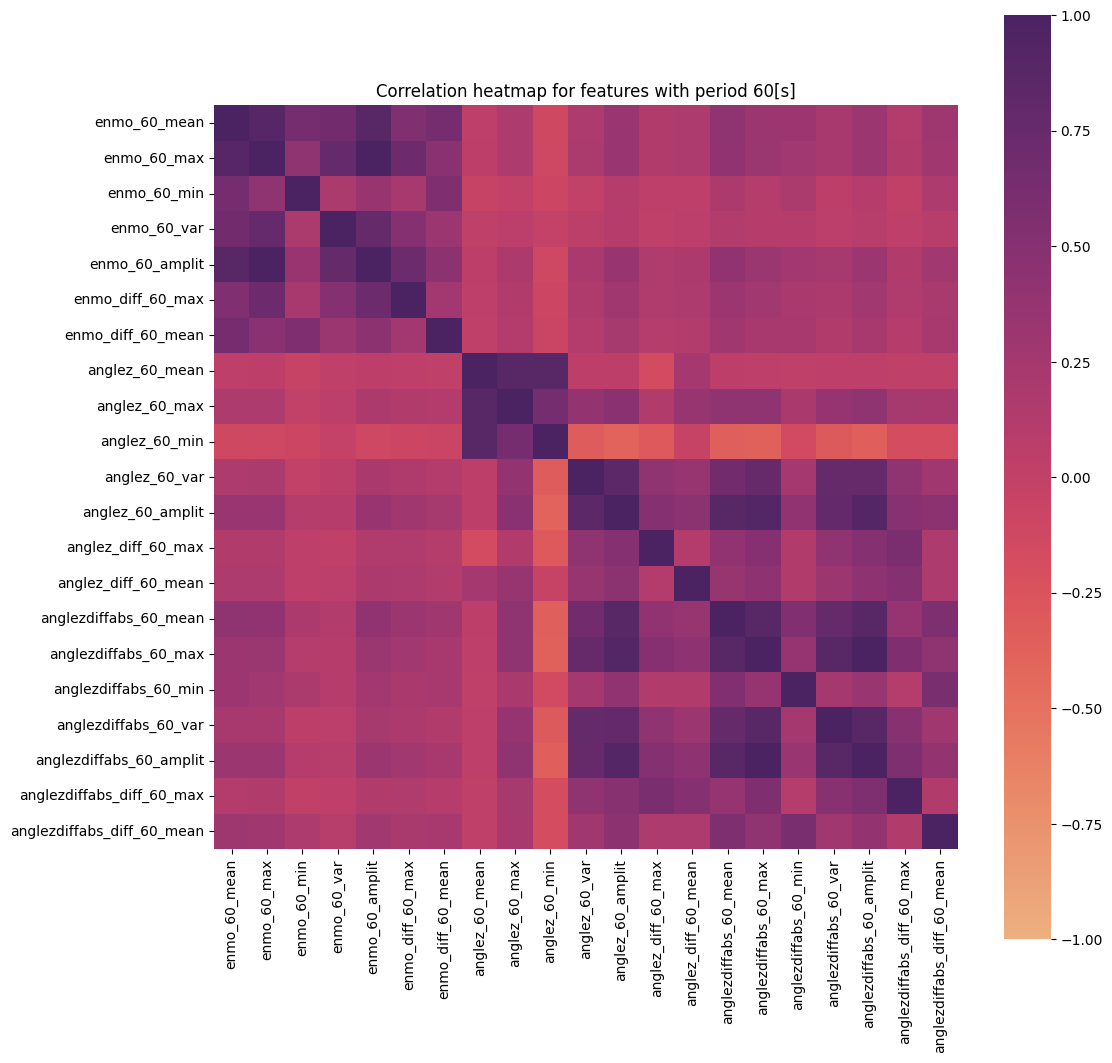

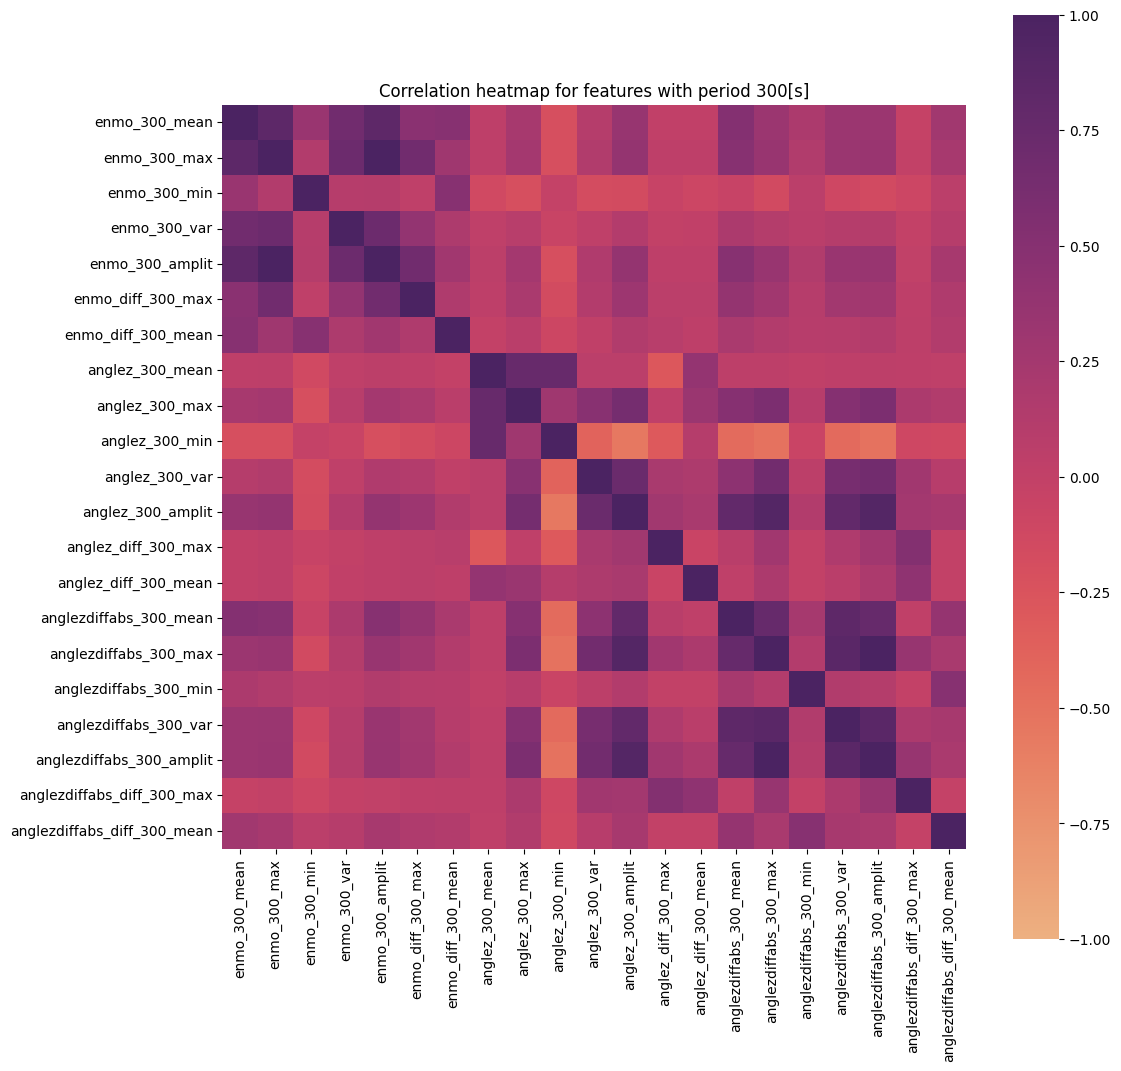

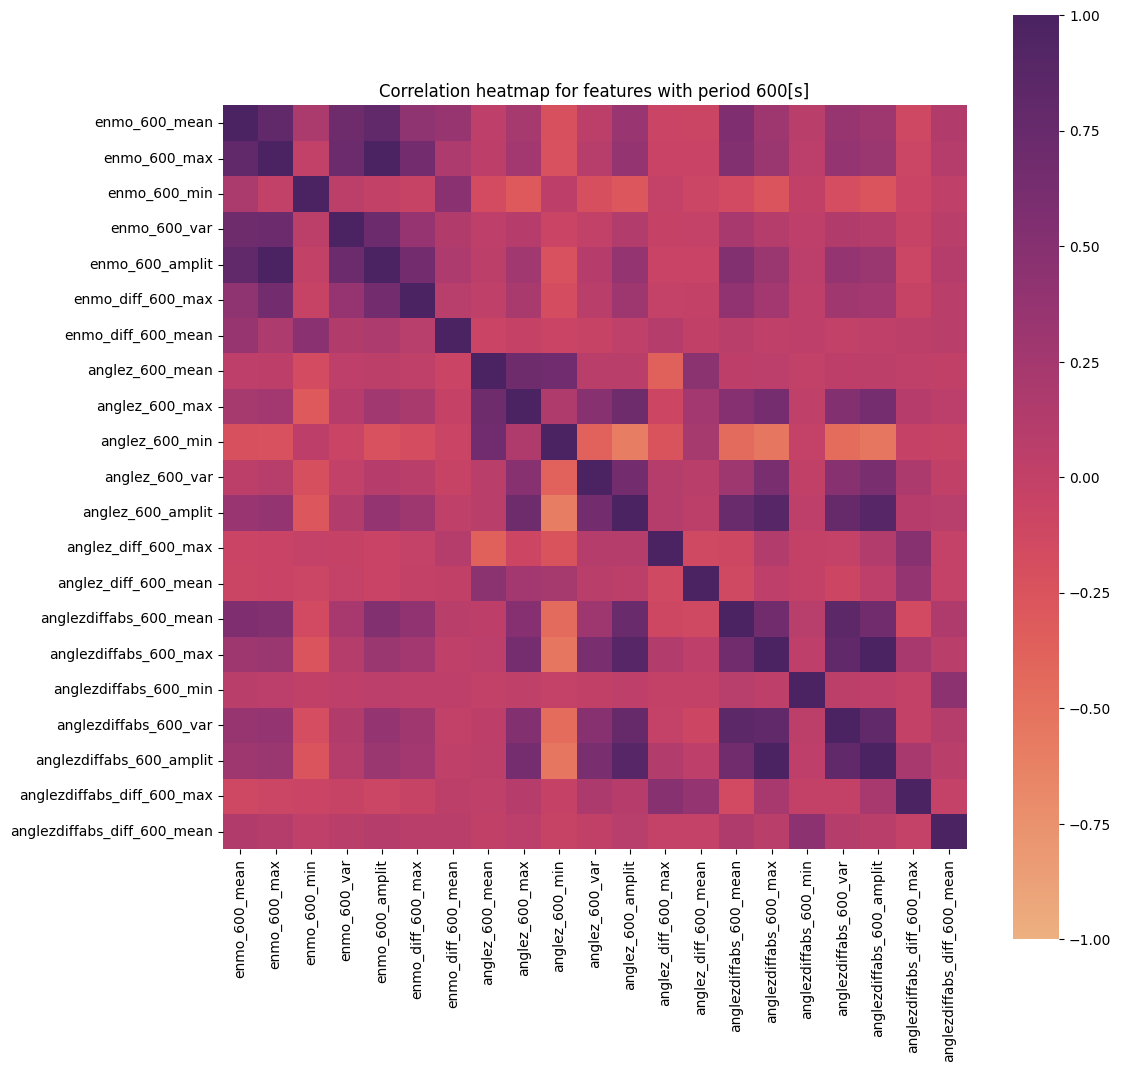

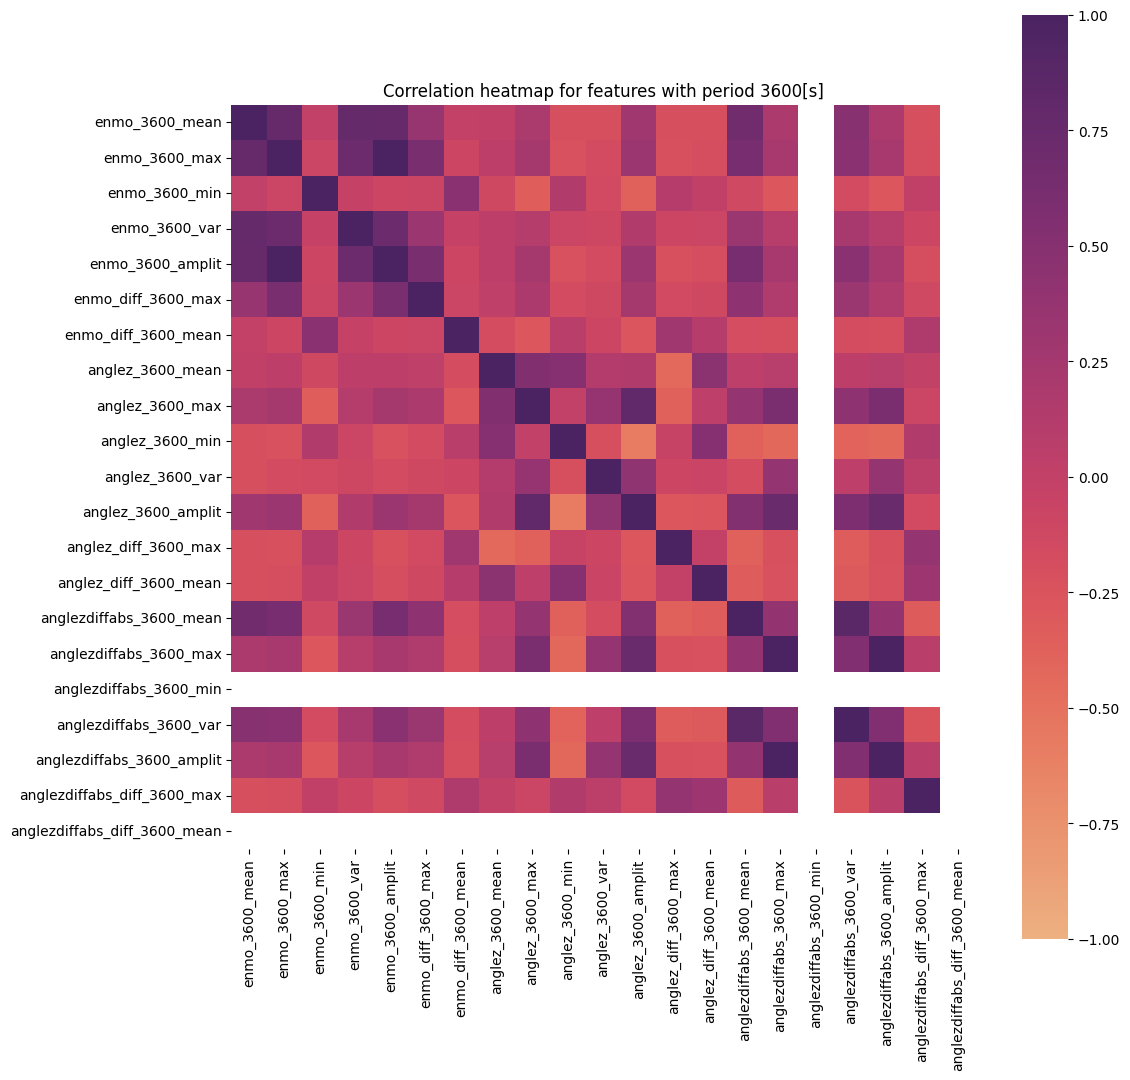

In [44]:
for p in periods:
    plt.figure(figsize=(12,12))
    plt.title(f"Correlation heatmap for features with period {p}[s]")
    sns.heatmap(df[features].filter(like=f'_{p}_').corr(),
    vmin=-1, vmax=1, center=0,
    cmap=sns.color_palette("flare", as_cmap=True),
    square=True)
    plt.show() 

In [45]:
features_to_drop = ['anglezdiffabs_3600_min', 'anglezdiffabs_600_min', 'anglezdiffabs_diff_3600_mean', 'anglezdiffabs_diff_600_mean',
                        'enmo_3600_min', 'enmo_600_min']
for p in periods:
    features_to_drop.append(f'anglezdiffabs_{p}_amplit')
    features_to_drop.append(f'enmo_{p}_amplit')

In [46]:
corr_with_target = df[features].corrwith(df['awake'])
corr_with_target.abs().sort_values().tail(50)

anglez_3600_min                 0.300191
anglez_3600_max                 0.301631
anglez_diff_3600_mean           0.302583
enmo_60_max                     0.305192
anglezdiffabs_diff_60_max       0.314172
enmo_diff_300_max               0.317025
anglezdiffabs_diff_3600_max     0.320073
anglezdiffabs_60_var            0.322677
enmo_60_mean                    0.325824
anglez_diff_60_max              0.337915
anglez_diff_60_mean             0.339530
anglezdiffabs_diff_60_mean      0.344148
anglezdiffabs                   0.347098
enmo_diff_600_max               0.348327
anglez_300_min                  0.360647
anglez_diff_3600_max            0.363111
enmo_300_max                    0.368225
enmo_300_amplit                 0.369672
anglez_600_min                  0.380604
anglez_300_max                  0.385129
enmo_300_mean                   0.387068
enmo_600_max                    0.404006
anglez_600_max                  0.405358
enmo_600_amplit                 0.405517
enmo_diff_3600_m

In [47]:
features_for_heatmap = corr_with_target.abs().sort_values().tail(27).index.to_list()
features_for_heatmap = [f for f in features_for_heatmap if f not in ['anglezdiffabs_3600_min','anglezdiffabs_diff_3600_mean']]

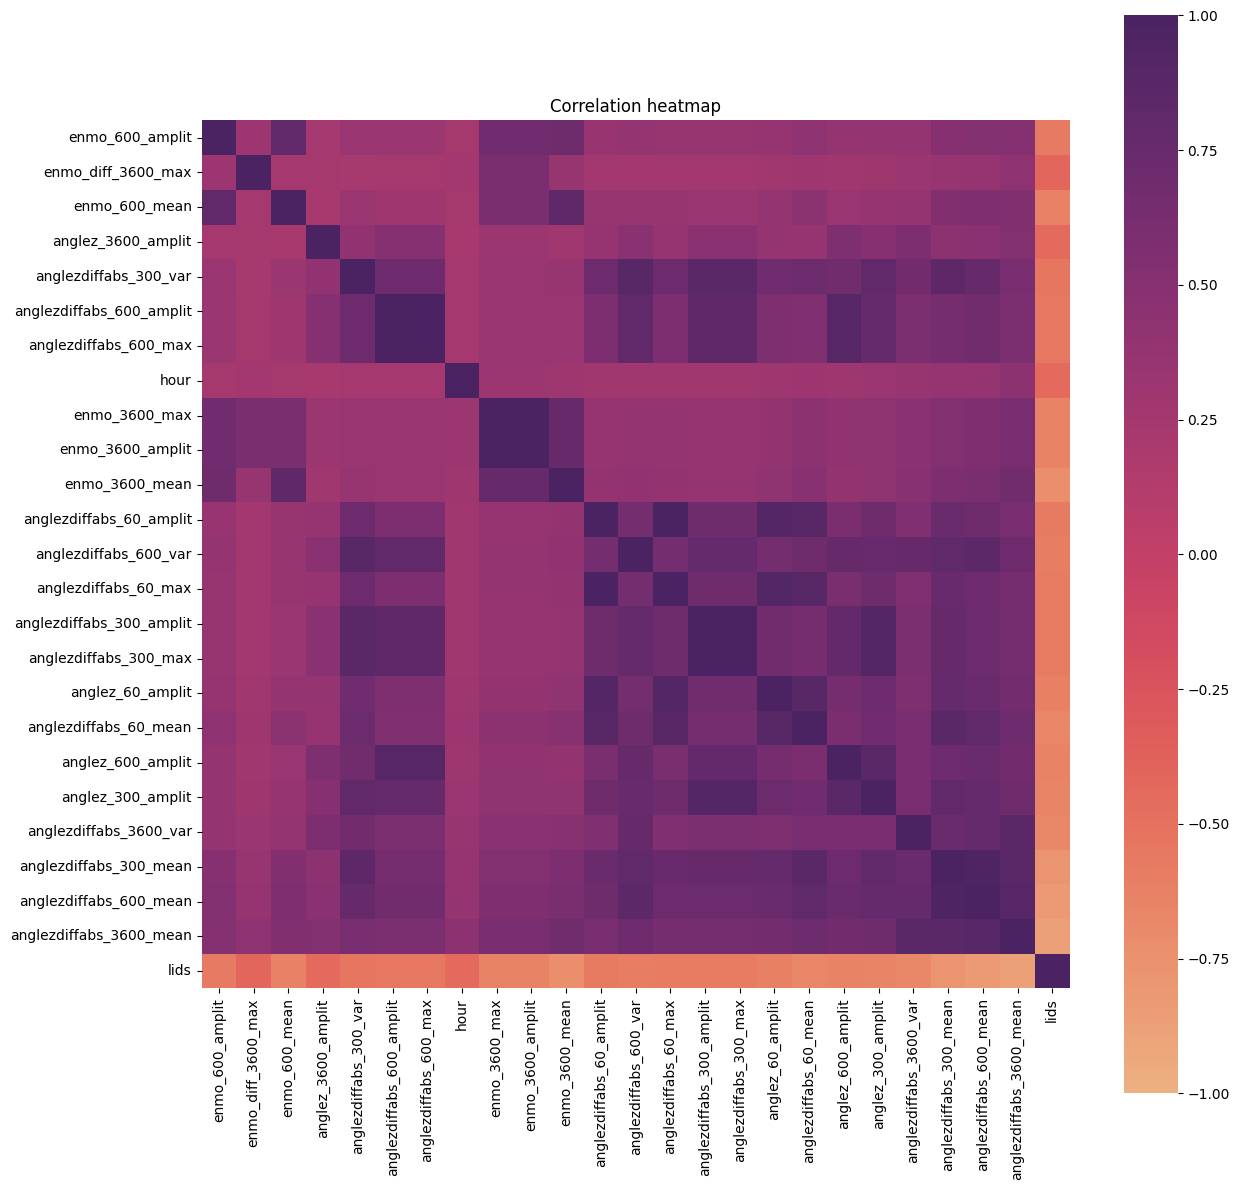

In [48]:
plt.figure(figsize=(14,14))
plt.title(f"Correlation heatmap")
sns.heatmap(df[features_for_heatmap].corr(),
vmin=-1, vmax=1, center=0,
cmap=sns.color_palette("flare", as_cmap=True),
square=True)
plt.show() 

In [49]:
df = df[::50]

### CatBoost

In [50]:
cat_params = {
    'iterations': 850,
    'depth': 6,
    'learning_rate': 0.03,
    'l2_leaf_reg': 0.05,
    'border_count': 200,
    'thread_count': -1,
    'verbose': 0,
    'random_seed': 42
}

In [51]:
def train_catboost_model(df, cv):
    
    drop_cols = ['series_id', 'step', 'timestamp']
    X, y = df.drop(columns=drop_cols+['awake']), df['awake']
    gc.collect()
    
    cv_split = cv.split(X)
    models = []
    mean_f1 = 0
    mean_acc = 0
    
    for i, (train_index, test_index) in enumerate(cv_split):

        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]
        
        print(f"Fitting model {i+1} of {cv.n_splits}")
        
        model = CatBoostClassifier(**cat_params)
        model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose_eval=50)
        
        preds = model.predict(X_test)
        f1 = f1_score(y_test, preds)
        acc = accuracy_score(y_test, preds)
        print(f"Fold {i+1} finished training\n F1:{f1_score(y_test, preds)} | Acc:{accuracy_score(y_test, preds)}")
        mean_f1 += f1
        mean_acc += acc
        models.append(model)
        
    print('-'*50)
    print(f"Training finished\nF1: {mean_f1 / cv.n_splits}, Acc: {mean_acc / cv.n_splits}")   
    gc.collect()
    
    return models

In [52]:
print("Fitting model with all features")
kf = KFold(n_splits=5, shuffle=True, random_state=42)
catboost_models = train_catboost_model(df, kf)

Fitting model with all features
Fitting model 1 of 5
0:	learn: 0.6327312	test: 0.6327714	best: 0.6327714 (0)	total: 151ms	remaining: 2m 8s
50:	learn: 0.0932783	test: 0.0932961	best: 0.0932961 (50)	total: 4.72s	remaining: 1m 14s
100:	learn: 0.0783300	test: 0.0788224	best: 0.0788224 (100)	total: 9.16s	remaining: 1m 7s
150:	learn: 0.0740177	test: 0.0749708	best: 0.0749708 (150)	total: 12.9s	remaining: 59.8s
200:	learn: 0.0708405	test: 0.0722510	best: 0.0722510 (200)	total: 17.4s	remaining: 56s
250:	learn: 0.0683493	test: 0.0703040	best: 0.0703040 (250)	total: 21.3s	remaining: 50.8s
300:	learn: 0.0663115	test: 0.0688267	best: 0.0688267 (300)	total: 25.2s	remaining: 46s
350:	learn: 0.0643326	test: 0.0673863	best: 0.0673863 (350)	total: 29s	remaining: 41.2s
400:	learn: 0.0624867	test: 0.0659962	best: 0.0659962 (400)	total: 33s	remaining: 37s
450:	learn: 0.0606423	test: 0.0646434	best: 0.0646434 (450)	total: 36.9s	remaining: 32.6s
500:	learn: 0.0589950	test: 0.0634448	best: 0.0634448 (500)	to

In [53]:
fi = pd.DataFrame([pd.Series(model.feature_importances_, index=features) for model in xgb_models])

In [54]:
fi

,anglez,enmo,hour,lids,anglezdiffabs,enmo_60_mean,enmo_60_max,enmo_60_min,enmo_60_var,enmo_60_amplit,...,anglezdiffabs_600_amplit,anglezdiffabs_diff_600_max,anglezdiffabs_diff_600_mean,anglezdiffabs_3600_mean,anglezdiffabs_3600_max,anglezdiffabs_3600_min,anglezdiffabs_3600_var,anglezdiffabs_3600_amplit,anglezdiffabs_diff_3600_max,anglezdiffabs_diff_3600_mean
0,0.001572,0.001674,0.013422,0.004614,0.001470,0.001953,0.002146,0.002403,0.008083,0.006926,...,0.001766,0.002488,0.002846,0.504524,0.005220,0.0,0.017860,0.0,0.003332,0.0
1,0.001599,0.001506,0.013746,0.005293,0.001295,0.001672,0.002540,0.002302,0.009460,0.002996,...,0.003035,0.002307,0.002861,0.487811,0.004952,0.0,0.016474,0.0,0.003513,0.0
2,0.001614,0.001166,0.013026,0.005105,0.002172,0.001724,0.001522,0.002781,0.005193,0.010419,...,0.001122,0.002339,0.003484,0.483969,0.005265,0.0,0.016833,0.0,0.003355,0.0
3,0.001669,0.001242,0.013177,0.004932,0.001284,0.001953,0.001677,0.002972,0.006972,0.009497,...,0.002471,0.002300,0.003838,0.497351,0.005308,0.0,0.016383,0.0,0.003513,0.0
4,0.001683,0.001382,0.014018,0.005020,0.001689,0.001896,0.002117,0.002703,0.007850,0.008560,...,0.006755,0.002307,0.001494,0.504506,0.005418,0.0,0.017288,0.0,0.003566,0.0


In [55]:
feature_importance = fi.mean(axis=0).sort_values()

<Axes: >

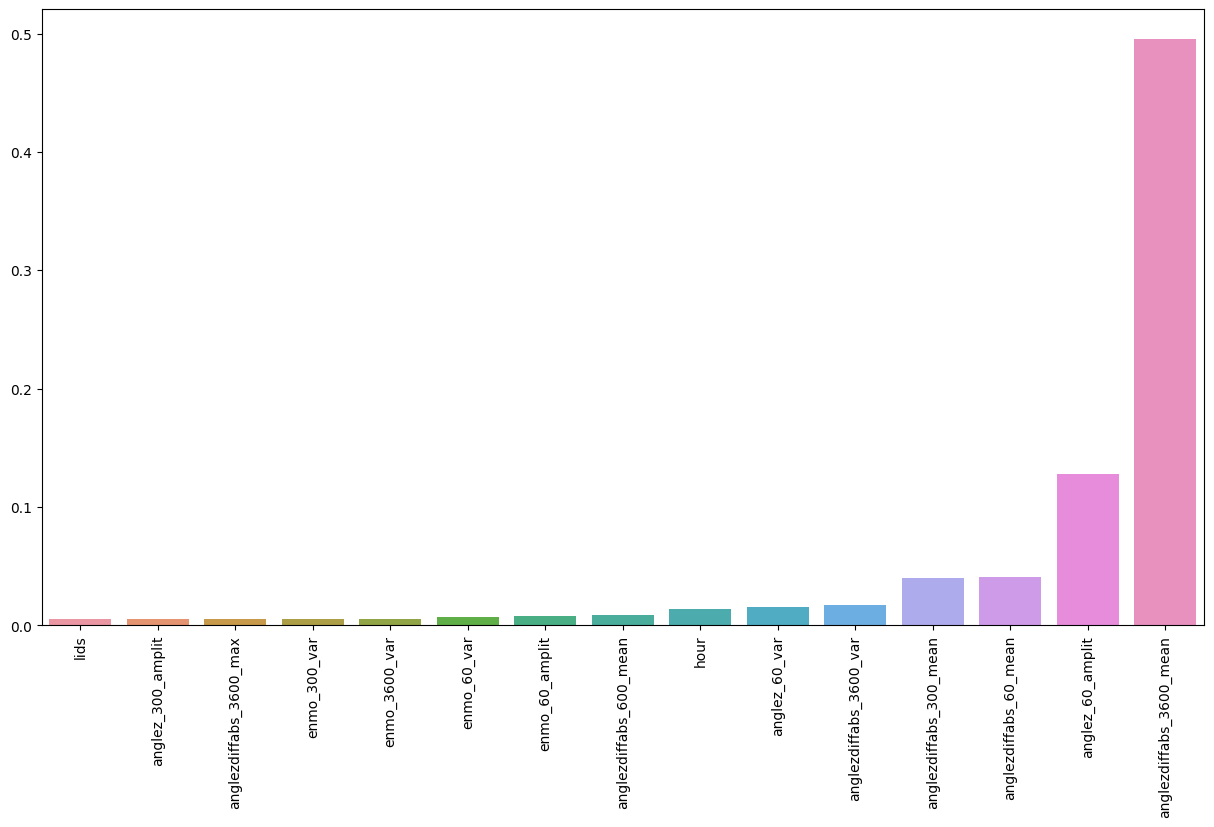

In [56]:
plt.figure(figsize=(15,8))
plt.xticks(rotation='vertical')
sns.barplot(x=feature_importance[-15:].index, y=feature_importance[-15:].values)